In [ ]:
!pip install pykrx
!pip install finance-datareader
!pip install pmdarima

     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 457 kB/s 
     |████████████████████████████████| 251 kB 36.1 MB/s 
     |████████████████████████████████| 48 kB 2.6 MB/s 
     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 32.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


No Korean fonts found. Please install the font shown belowbecause Hangul can be broken on the chart.
 - NanumBarunGothic font is required.

    1) font install

    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

    2) runtime restart if colab
    
PYKRX works fine regardless of font installation.


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


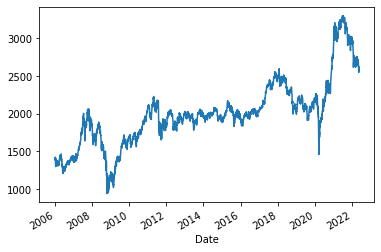

In [ ]:
from pykrx import stock
from pykrx import bond
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

df = fdr.DataReader('KS11', '2006')
df['Close'].plot()

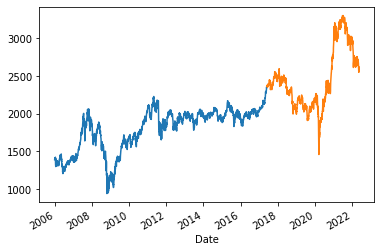

In [ ]:
y_train = df['Close'][:int(0.7*len(df))]
y_test = df['Close'][int(0.7*len(df)):]
y_train.plot()
y_test.plot()

In [ ]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [ ]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25191.692, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25192.748, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25192.702, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25190.472, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25193.363, Time=1.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.277 seconds


In [ ]:
model = pm.auto_arima (y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25195.881, Time=7.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25191.692, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25192.748, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25192.702, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25190.472, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25193.363, Time=2.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 11.121 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2833
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -12594.236
Date:                Tue, 17 May 2022   AIC                          25190.472
Time:                        07:15:19   BIC                          25196.421
Sample:                             0   HQIC                         25192.618
                               - 2833                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       426.8183      6.646     64.217      0.000     413.791     439.845
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):              1874.99
Prob(Q):                              0.33   Pr

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


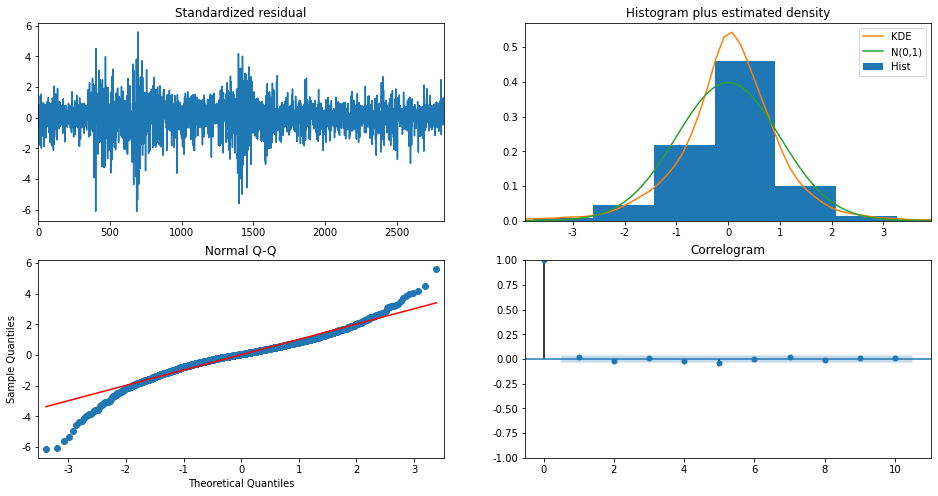

In [ ]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

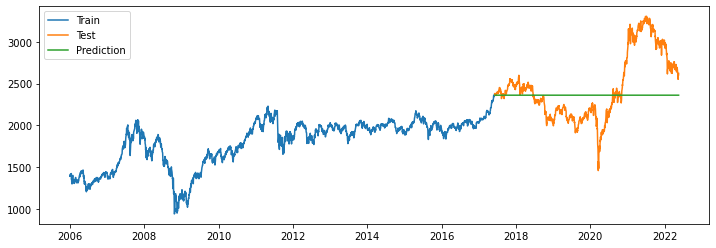

In [ ]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [ ]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [ ]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [ ]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2017-06-08,2363.57,2360.14
2017-06-09,2381.69,2363.57
2017-06-12,2357.87,2381.69
2017-06-13,2374.70,2357.87
2017-06-14,2372.64,2374.70
...,...,...
2022-05-11,2592.27,2596.56
2022-05-12,2550.08,2592.27
2022-05-13,2604.24,2550.08


In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4048
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -18336.138
Date:                Tue, 17 May 2022   AIC                          36674.276
Time:                        07:16:41   BIC                          36680.582
Sample:                             0   HQIC                         36676.510
                               - 4048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       504.6722      6.708     75.239      0.000     491.526     517.819
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):              2304.47
Prob(Q):                              0.33   Pr

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 0.787




---



---



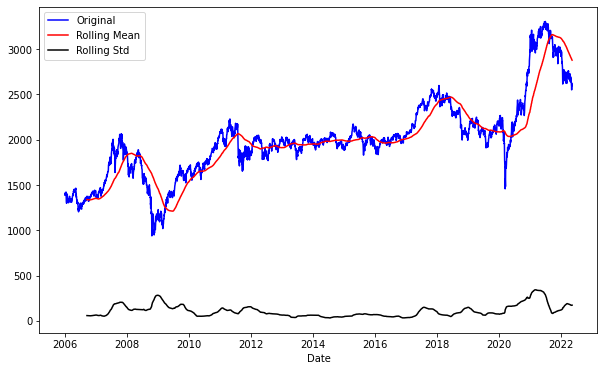

In [ ]:
def plot_rolling(data, interval):
 rolmean = data.rolling(interval).mean()
 rolstd = data.rolling(interval).std()
 #Plot rolling statistics:
 plt.figure(figsize=(10, 6))
 plt.xlabel('Date')
 orig = plt.plot(data, color='blue',label='Original')
 mean = plt.plot(rolmean, color='red', label='Rolling Mean')
 std = plt.plot(rolstd, color='black', label = 'Rolling Std')
 plt.legend(loc='best')
 plt.show()
plot_rolling(df['Close'], 180)

In [ ]:
from statsmodels.tsa.stattools import adfuller
y = df['Close']
y_1diff = df.diff().dropna()['Close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -1.609
원 데이터 p-value: 0.479
1차 차분 ADF Statistic: -62.609
1차 차분 p-value: 0.000


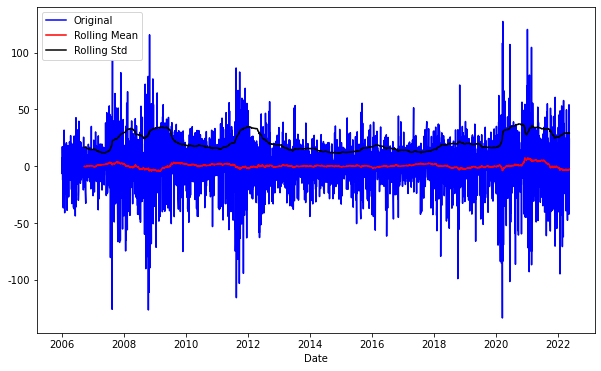

In [ ]:
def plot_rolling(data, interval):
 rolmean = data.rolling(interval).mean()
 rolstd = data.rolling(interval).std()
 #Plot rolling statistics:
 plt.figure(figsize=(10, 6))
 plt.xlabel('Date')
 orig = plt.plot(data, color='blue',label='Original')
 mean = plt.plot(rolmean, color='red', label='Rolling Mean')
 std = plt.plot(rolstd, color='black', label = 'Rolling Std')
 plt.legend(loc='best')
 plt.show()
plot_rolling(y_1diff, 180)

In [ ]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q))

                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df

my_auto_arima(df['Close'],[3,3,3])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided,

,order,AIC
3,p0 d1 q0,36674.276295
23,p2 d1 q2,36674.319048
12,p1 d1 q0,36675.287523
4,p0 d1 q1,36675.326387
5,p0 d1 q2,36675.582410
21,p2 d1 q0,36675.597214
7,p0 d2 q1,36675.872351
13,p1 d1 q1,36676.545240
16,p1 d2 q1,36676.795364
8,p0 d2 q2,36676.891440


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4048
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -18332.160
Date:                Tue, 17 May 2022   AIC                          36674.319
Time:                        07:17:26   BIC                          36705.848
Sample:                             0   HQIC                         36685.489
                               - 4048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3313      0.073     18.212      0.000       1.188       1.475
ar.L2         -0.8798      0.065    -13.478      0.000      -1.008      -0.752
ma.L1         -1.3104      0.075    -17.508      0.0

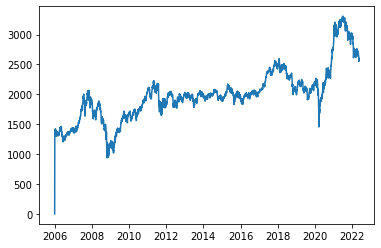

In [ ]:
model = ARIMA(df['Close'], order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())
a = model_fit.predict()
print(a)
plt.plot(a)

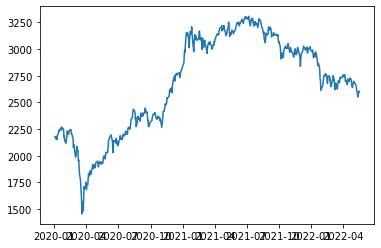

In [ ]:
b = model_fit.predict(start=datetime.datetime(2020,1,3))
plt.plot(b)

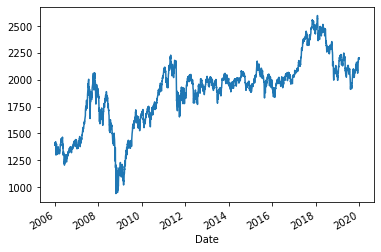

In [ ]:
df1 = fdr.DataReader('KS11', '2006-01-01', '2019-12-31')
df1['Close'].plot()

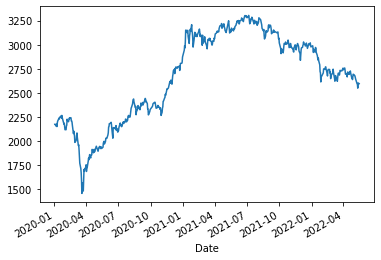

In [ ]:
df2 = fdr.DataReader('KS11', '2020-01-01', '2022-05-16')
df2['Close'].plot()

In [ ]:
train = df['Close'].loc[:datetime.datetime(2019,12,31),:], 
test = df['Close'].loc[datetime.datetime(2019,12,31):,:]

IndexingError: ignored

In [ ]:
train = df1['Close']
test = df2['Close']
model = ARIMA(train,(2,1,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns=test.columns)
plt.plot(train.loc[datetime.datetime(2018,12,31):,:])
plt.plot(test)
plt.plot(forecast)



---



---

